 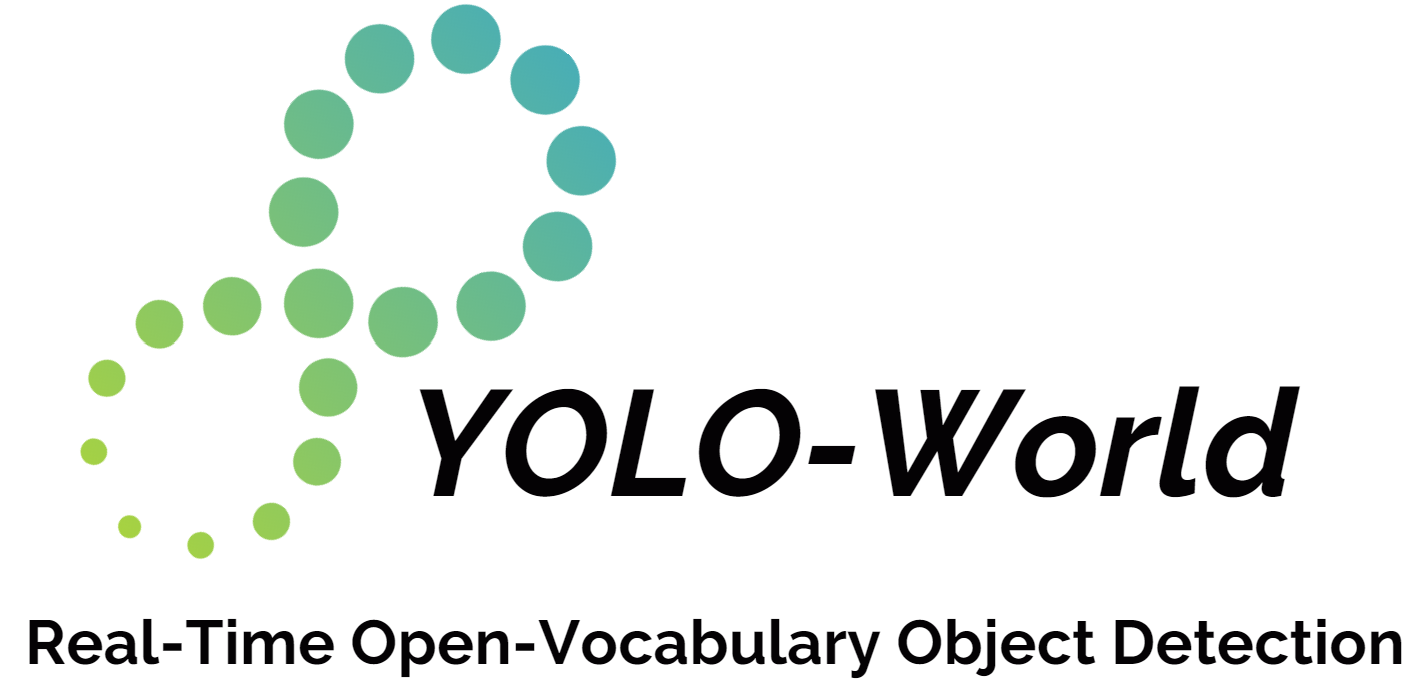


 This YOLO-World notebook is a Inferencing notebook presenting Real-Time Open-Vocabulary Object Detection.

We hope that the resources in this notebook will help you for inferencing.

## Setup

Clone GitHub [repository](https://github.com/AILab-CVC/YOLO-World) and install dependencies

In [ ]:
!git clone --recursive https://github.com/AILab-CVC/YOLO-World
%cd YOLO-World/

In [1]:
import os
# Install certain version of requests, tqdm, rich for openxlab (fix for yolo_world)
# Install mmcv before avoding compiling of mmcv and shortining waiting time installs "whl" file
# Downgrade pytorch version for fast installing mmcv (your on prem should finish faster with latest pytorch)


if 'COLAB_GPU' in os.environ:
  !pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 --index-url https://download.pytorch.org/whl/cu121 -q
  !pip install requests==2.28.2 tqdm==4.65.0 rich==13.4.2 -q
  %pip install -U openmim -q
  !mim install "mmengine>=0.7.0" -q
  !mim install "mmcv" -q
else:
  !pip install torch wheel requests==2.28.2 tqdm==4.65.0 rich==13.4.2 -q

!pip install -e . -vv -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yolo-world 0.1.0 requires mmcv, which is not installed.
yolo-world 0.1.0 requires mmcv-lite>=2.0.0rc4, which is not installed.
Using pip 24.1.1 from /home/hhy_2023/anaconda3/envs/pytorch1.13/lib/python3.10/site-packages/pip (python 3.10)
Obtaining file:///home/hhy_2023/aaaacode/YOLO-World/demo
ERROR: file:///home/hhy_2023/aaaacode/YOLO-World/demo does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [3]:
if 'COLAB_GPU' in os.environ:
    # Restart colab session (required for yolo_world to work in google colab)
    quit()

## Pretrained Models

Download Pretrained weights from Huggingface and set configuration

In [2]:
import os

%cd YOLO-World/
if not os.path.exists("pretrained_weights"):
    os.makedirs("pretrained_weights")

# Download pretrained weights of YOLO-Worldv2-L	O365+GoldG img_size=1280 model
!wget -P pretrained_weights/ https://huggingface.co/wondervictor/YOLO-World/resolve/main/yolo_world_v2_l_obj365v1_goldg_pretrain_1280ft-9babe3f6.pth
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

[Errno 2] No such file or directory: 'YOLO-World/'
/home/hhy_2023/aaaacode/YOLO-World/demo
--2024-07-03 21:03:24--  https://huggingface.co/wondervictor/YOLO-World/resolve/main/yolo_world_v2_l_obj365v1_goldg_pretrain_1280ft-9babe3f6.pth
Connecting to 127.0.0.1:7892... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/60/37/6037308e29abfdfd0058944e23eef6e0985d74bbb91fb2823de37a9ddfc4cc89/9babe3f6e2b73cd64f545b59de358fc7c47a85059cda9767f0a69f6bfae42d6d?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27yolo_world_v2_l_obj365v1_goldg_pretrain_1280ft-9babe3f6.pth%3B+filename%3D%22yolo_world_v2_l_obj365v1_goldg_pretrain_1280ft-9babe3f6.pth%22%3B&Expires=1720271005&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMDI3MTAwNX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzYwLzM3LzYwMzczMDhlMjlhYmZkZmQwMDU4OTQ0ZTIzZWVmNmUwOTg1ZDc0YmJiOTFmYjI4MjNkZTM3YTl

## Loading model configurations

In [15]:
import numpy as np
import torch
from mmengine.config import Config
from mmengine.dataset import Compose
from mmengine.runner import Runner
from mmengine.runner.amp import autocast
from mmyolo.registry import RUNNERS
from torchvision.ops import nms


if __name__ == "__main__":
    # load config
    cfg = Config.fromfile(
        "configs/pretrain/yolo_world_v2_l_vlpan_bn_2e-3_100e_4x8gpus_obj365v1_goldg_train_1280ft_lvis_minival.py"
    )
    cfg.work_dir = "."
    cfg.load_from = "pretrained_weights/yolo_world_v2_l_obj365v1_goldg_pretrain_1280ft-9babe3f6.pth"
    runner = Runner.from_cfg(cfg)
    runner.call_hook("before_run")
    runner.load_or_resume()
    pipeline = cfg.test_dataloader.dataset.pipeline
    runner.pipeline = Compose(pipeline)
    
    # run model evaluation
    runner.model.eval()

07/04 15:58:48 - mmengine - WARNING - Failed to search registry with scope "mmyolo" in the "log_processor" registry tree. As a workaround, the current "log_processor" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmyolo" is a correct scope, or whether the registry is initialized.
07/04 15:58:48 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 735367045
    GPU 0,1: NVIDIA GeForce RTX 4090
    CUDA_HOME: /usr/local/cuda-11.6
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 1.13.0
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 20

In [16]:
print('pipeline:',runner.pipeline)

pipeline: Compose(
    LoadImageFromFile(ignore_empty=False, to_float32=False, color_type='color', imdecode_backend='cv2', backend_args=None)
    YOLOv5KeepRatioResize(scale=(1280, 1280), scale_factor=None, keep_ratio=True, clip_object_border=True), backend=cv2), interpolation=bilinear)
    LetterResize(scale=(1280, 1280), scale_factor=None, keep_ratio=True, clip_object_border=True), backend=cv2), interpolation=bilinear)
    LoadAnnotations(with_bbox=True, with_label=True, with_mask=False, with_seg=False, poly2mask=True, imdecode_backend='cv2', backend_args=None)
    PackDetInputs(meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape', 'scale_factor', 'pad_param', 'texts'))
)


In [17]:
def colorstr(*input):
    """
        Helper function for style logging
    """
    *args, string = input if len(input) > 1 else ("bold", input[0])
    colors = {"bold": "\033[1m"}

    return "".join(colors[x] for x in args) + f"{string}"

# Run Image Inference

In [19]:
import PIL.Image
import cv2
import supervision as sv

bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_position=sv.Position.CENTER)
mask_annotator = sv.MaskAnnotator()

class_names = ("person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, "
               "traffic light, fire hydrant, stop sign, parking meter, bench, bird, "
               "cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, "
               "backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, "
               "sports ball, kite, baseball bat, baseball glove, skateboard, "
               "surfboard, tennis racket, bottle, wine glass, cup, fork, knife, "
               "spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, "
               "hot dog, pizza, donut, cake, chair, couch, potted plant, bed, "
               "dining table, toilet, tv, laptop, mouse, remote, keyboard, "
               "cell phone, microwave, oven, toaster, sink, refrigerator, book, "
               "clock, vase, scissors, teddy bear, hair drier, toothbrush")

class_names2 = ("tie")


def run_image(
        runner,
        input_image,
        max_num_boxes=100,
        score_thr=0.2,
        nms_thr=0.3,
        output_image="output.png",
):
    output_image = "runs/detect/"+output_image
    texts = [[t.strip()] for t in class_names2.split(",")] + [[" "]]
    print(texts)
    data_info = runner.pipeline(dict(img_id=0, img_path=input_image,
                                     texts=texts))

    data_batch = dict(
        inputs=data_info["inputs"].unsqueeze(0),
        data_samples=[data_info["data_samples"]],
    )

    with autocast(enabled=False), torch.no_grad():
        output = runner.model.test_step(data_batch)[0]
        runner.model.class_names = texts
        pred_instances = output.pred_instances

    # nms
    keep_idxs = nms(pred_instances.bboxes, pred_instances.scores, iou_threshold=nms_thr)
    pred_instances = pred_instances[keep_idxs]
    pred_instances = pred_instances[pred_instances.scores.float() > score_thr]

    if len(pred_instances.scores) > max_num_boxes:
        indices = pred_instances.scores.float().topk(max_num_boxes)[1]
        pred_instances = pred_instances[indices]
    output.pred_instances = pred_instances

    # predictions
    pred_instances = pred_instances.cpu().numpy()

    if 'masks' in pred_instances:
        masks = pred_instances['masks']
    else:
        masks = None
        
    detections = sv.Detections(
        xyxy=pred_instances['bboxes'],
        class_id=pred_instances['labels'],
        confidence=pred_instances['scores']
    )

    # label ids with confidence scores
    labels = [
        f"{class_id} {confidence:0.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    # draw bounding box with label
    image = PIL.Image.open(input_image)
    svimage = np.array(image)
    svimage = bounding_box_annotator.annotate(svimage, detections)
    svimage = label_annotator.annotate(svimage, detections, labels)
    if masks is not None:
        svimage = mask_annotator.annotate(image, detections)

    # save output image
    cv2.imwrite(output_image, svimage[:, :, ::-1])
    print(f"Results saved to {colorstr('bold', output_image)}")

    return svimage[:, :, ::-1]


[['tie'], [' ']]
Results saved to runs/detect/output.png


SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


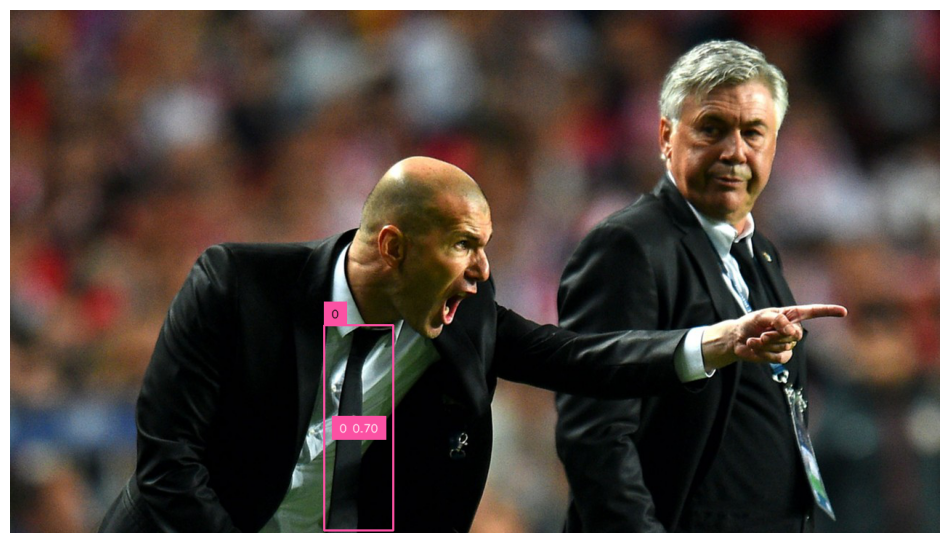

In [20]:
img = run_image(runner,"zidane.jpg")
sv.plot_image(img)